# Generative Models PHW4: Energy-Based Models

Name: mohamad hosein mehdikhani

Student ID: 400102039

## Setup

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
import random

In [22]:
computation_device = ("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")
print(f"Using {computation_device} device")

# Dataset setup: MNIST with normalization
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Using cuda device


# Dataset (10 points)

Load the `MNIST` dataset and normalize the images between -1 and 1 as this makes the implementation easier.

In [23]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_batch_size = 64

# Load datasets
training_set = datasets.MNIST(root='./data', train=True, transform=transformations, download=True)
testing_set = datasets.MNIST(root='./data', train=False, transform=transformations, download=True)

# Create data loaders
training_loader = DataLoader(training_set, batch_size=data_batch_size, shuffle=True)
testing_loader = DataLoader(testing_set, batch_size=data_batch_size, shuffle=False)


# Langevin Dynamics (20 points)

The Langevin dynamics in our case starts with a randomly initialized $x_0$ and then uses the information about the landscape of the energy function
(i.e., the gradient) to seek for new $x$, that is:
$$x_{t+1} = x_{t} + \alpha \nabla_{x_t}\text{LogSumExp} \left[f_{\theta} (x) \right] + \sigma \cdot \epsilon$$

where $\alpha, \sigma > 0$ and $\epsilon \sim \mathcal{N}(0, I)$. The Langevin dynamics could be seen as the stochastic gradient descent in the observable space with a small Gaussian noise added at each step.

Our goal is to run the Langevin dynamics for $\eta$ iterations with the steps size $\alpha$ and the noise level equal $\sigma$.

In [24]:
def langevin_dynamics(model, initial_samples, steps=20, alpha=0.01, noise_level=0.01):
    current_samples = initial_samples.clone().detach().requires_grad_(True)
    for _ in range(steps):
        energy_output = model(current_samples)
        total_energy = energy_output.sum()
        gradient = torch.autograd.grad(total_energy, current_samples)[0]
        noise = torch.randn_like(current_samples).to(computation_device) * noise_level
        current_samples = current_samples - alpha * gradient + noise
        current_samples = torch.clamp(current_samples, -1.0, 1.0)
    return current_samples.detach()

# Loss (15 points)

We can evaluate our model using the following objective:

$$\mathcal{L} = \mathcal{L}_\text{clf}(\theta) + \mathcal{L}_\text{gen}(\theta)$$

Where $\mathcal{L}_\text{clf}(\theta)$ is the cross-entropy loss and $\mathcal{L}_\text{gen}(\theta)$ is an approximation to the log-marginal distribution over images (for example the LogSumExp loss).

In [25]:
def compute_loss(model, pos_samples, steps, alpha=0.01, noise_level=0.01):
    positive_energy = model(pos_samples)[0]
    neg_samples = torch.rand_like(pos_samples, device=computation_device) * 2 - 1
    neg_samples = langevin_dynamics(model, neg_samples, steps, alpha, noise_level)
    negative_energy = model(neg_samples)[0]
    contrastive_loss = torch.mean(positive_energy) - torch.mean(negative_energy)
    return contrastive_loss, neg_samples

def total_loss(model, inputs, targets, steps, alpha=0.01, noise_level=0.01):
    loss_contrastive, gen_negatives = compute_loss(model, inputs, steps, alpha, noise_level)
    _, _, loss_classification = model(inputs, targets)
    total_loss_value = loss_contrastive + loss_classification
    return total_loss_value, gen_negatives


# Neural Network (10 points)

Define the neural network that specifies the energy function.
The inputs should be images and the outputs must be the classes.
Don't forget to use appropriate activation functions!

In [26]:
class DynamicEnergyNet(nn.Module):
    def __init__(self):
        super(DynamicEnergyNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2),
            nn.SiLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.SiLU(),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.SiLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x, labels=None):
        x_features = self.features(x)
        x_logits = x_features
        x_energy = torch.logsumexp(x_logits, dim=1)
        if labels is not None:
            probs = F.softmax(x_logits, dim=1)
            loss_cls = nn.CrossEntropyLoss()(x_logits, labels)
            return x_logits, x_energy, loss_cls
        return x_energy


# Visualize (15 points)

Create the following functions to be able to visualize real and generated images.

In [27]:
def show_generated_samples(model, grid_dim=8, langevin_steps=20):
    model.eval()
    init_noise = torch.rand((grid_dim * grid_dim, 1, 28, 28), device=computation_device) * 2 - 1
    generated_images = langevin_dynamics(model, init_noise, steps=langevin_steps)
    fig, axes = plt.subplots(grid_dim, grid_dim, figsize=(grid_dim, grid_dim))
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(generated_images[idx].cpu().squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def display_images(images, title, num_images=8):
    images = images.view(-1, 28, 28).cpu().numpy()
    fig, axes = plt.subplots(1, num_images, figsize=(12, 2))
    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Training (15 points)

Fill in the evaluation and training functions. Make sure you track the loss and plot it to analyze possible issues.

In [28]:
def train_model(model, train_loader, test_loader, optimizer, epochs=10, langevin_steps=20):
    train_losses = []
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        total_epoch_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, targets = inputs.to(computation_device), targets.to(computation_device)
            loss, neg_samples = total_loss(model, inputs, targets, langevin_steps)
            total_epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        avg_loss = total_epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(computation_device), targets.to(computation_device)
                outputs, _, _ = model(inputs, targets)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)
        display_images(neg_samples[:8], title=f"Generated Mnists at Epoch {epoch+1}")

    return train_losses, val_accuracies


Now define the optimizer and train your model.

Epoch 1/30: 100%|██████████| 938/938 [01:07<00:00, 13.86it/s]


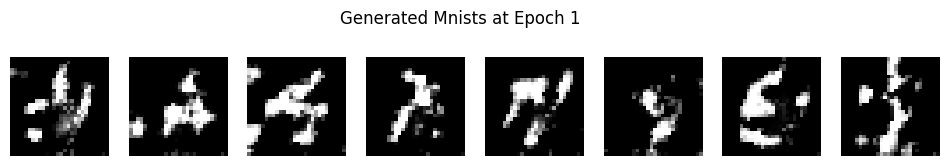

Epoch 2/30: 100%|██████████| 938/938 [01:06<00:00, 14.14it/s]


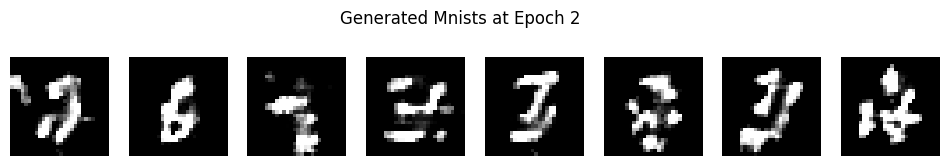

Epoch 3/30: 100%|██████████| 938/938 [01:06<00:00, 14.17it/s]


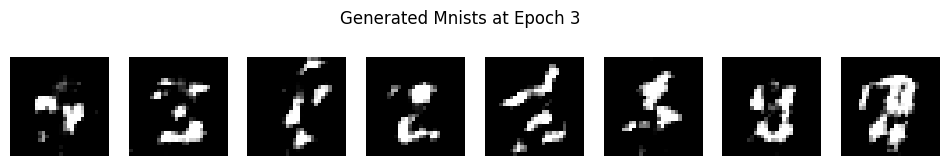

Epoch 4/30: 100%|██████████| 938/938 [01:06<00:00, 14.07it/s]


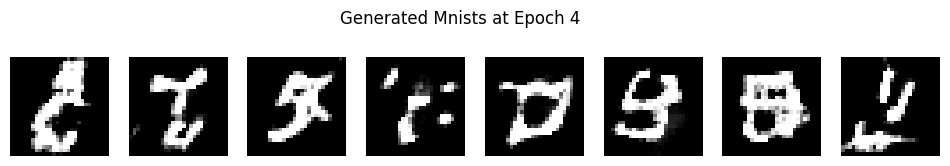

Epoch 5/30: 100%|██████████| 938/938 [01:06<00:00, 14.15it/s]


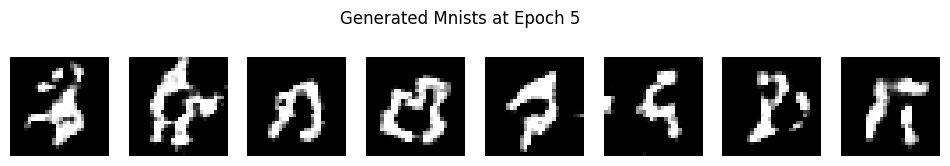

Epoch 6/30: 100%|██████████| 938/938 [01:06<00:00, 14.02it/s]


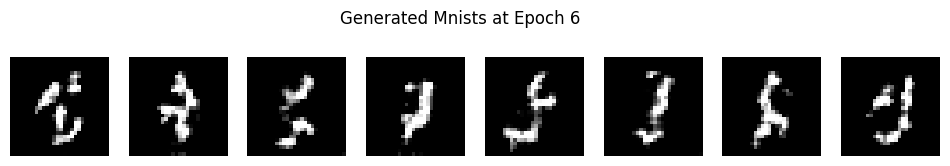

Epoch 7/30: 100%|██████████| 938/938 [01:06<00:00, 14.21it/s]


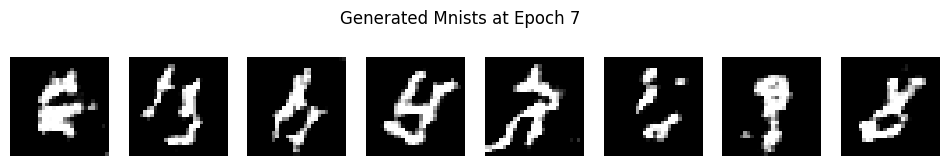

Epoch 8/30: 100%|██████████| 938/938 [01:04<00:00, 14.45it/s]


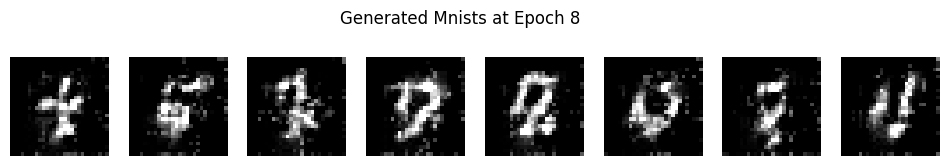

Epoch 9/30: 100%|██████████| 938/938 [01:05<00:00, 14.39it/s]


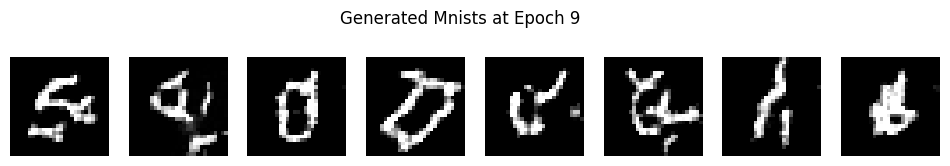

Epoch 10/30: 100%|██████████| 938/938 [01:04<00:00, 14.50it/s]


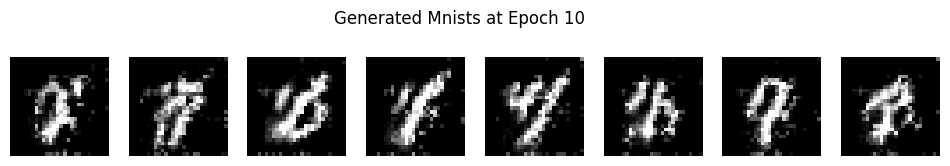

Epoch 11/30: 100%|██████████| 938/938 [01:06<00:00, 14.09it/s]


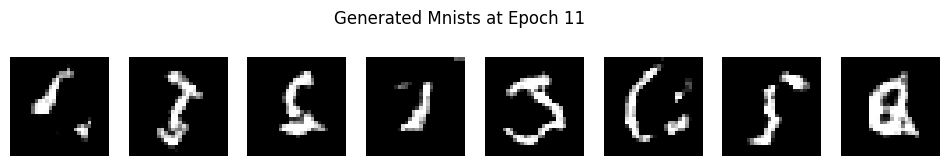

Epoch 12/30: 100%|██████████| 938/938 [01:06<00:00, 14.02it/s]


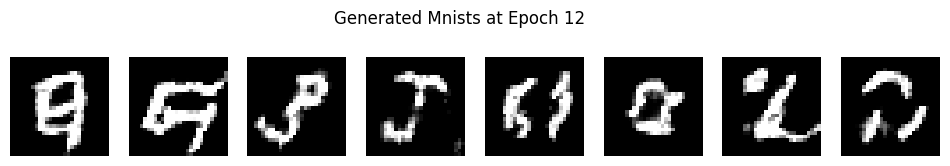

Epoch 13/30: 100%|██████████| 938/938 [01:06<00:00, 14.18it/s]


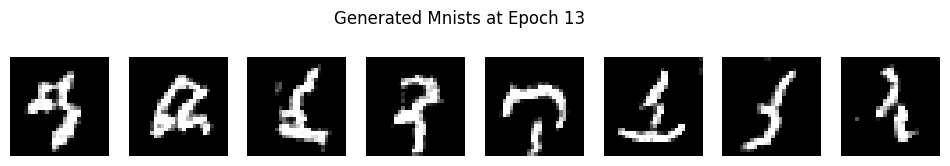

Epoch 14/30: 100%|██████████| 938/938 [01:04<00:00, 14.50it/s]


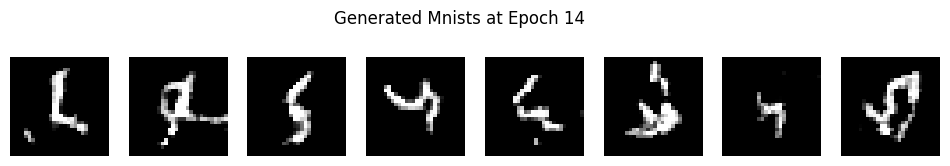

Epoch 15/30: 100%|██████████| 938/938 [01:05<00:00, 14.27it/s]


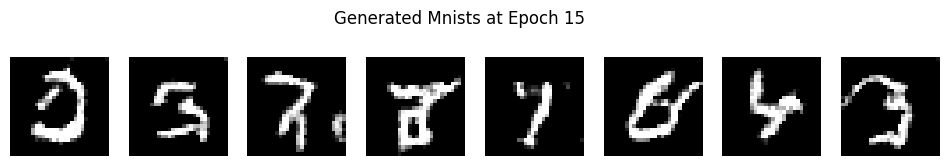

Epoch 16/30: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


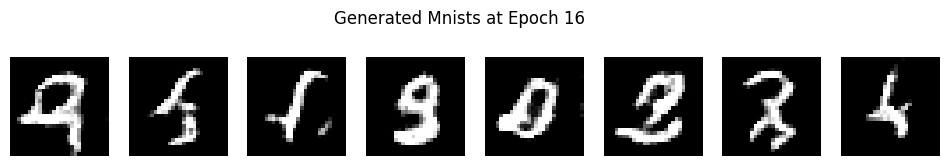

Epoch 17/30: 100%|██████████| 938/938 [01:05<00:00, 14.42it/s]


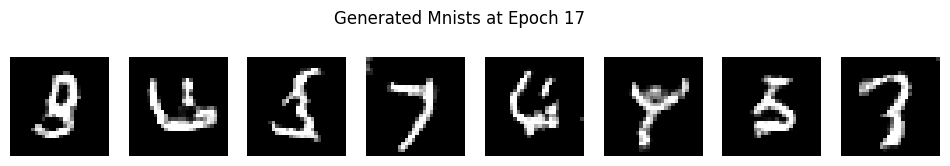

Epoch 18/30: 100%|██████████| 938/938 [01:07<00:00, 13.90it/s]


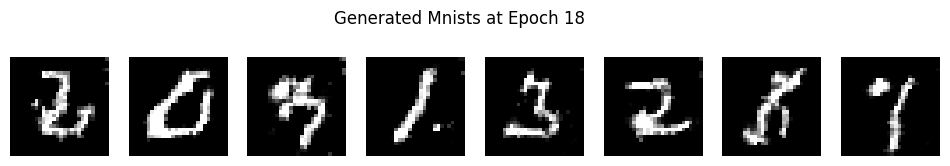

Epoch 19/30: 100%|██████████| 938/938 [01:07<00:00, 13.93it/s]


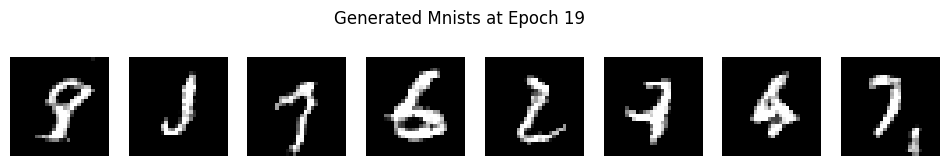

Epoch 20/30: 100%|██████████| 938/938 [01:07<00:00, 13.99it/s]


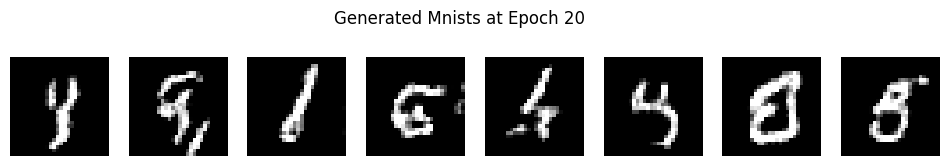

Epoch 21/30: 100%|██████████| 938/938 [01:06<00:00, 14.09it/s]


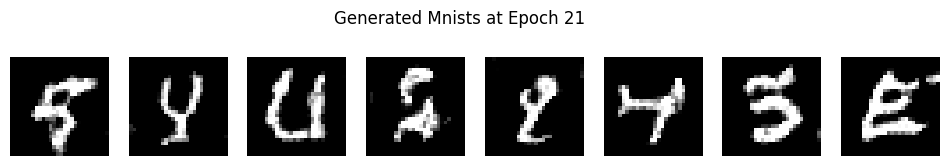

Epoch 22/30: 100%|██████████| 938/938 [01:07<00:00, 13.91it/s]


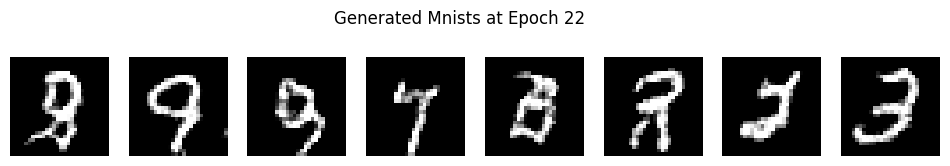

Epoch 23/30: 100%|██████████| 938/938 [01:07<00:00, 13.85it/s]


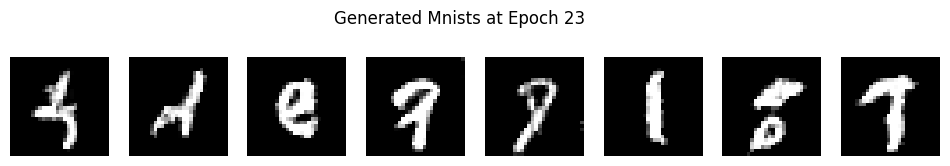

Epoch 24/30: 100%|██████████| 938/938 [01:07<00:00, 13.85it/s]


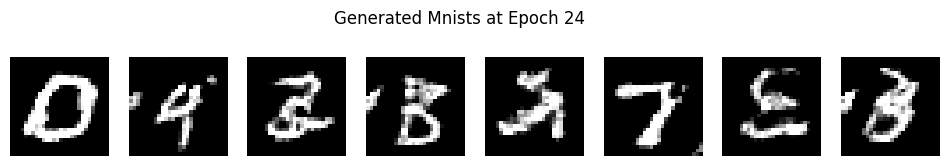

Epoch 25/30: 100%|██████████| 938/938 [01:06<00:00, 14.17it/s]


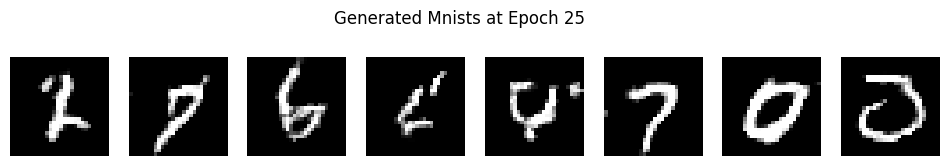

Epoch 26/30: 100%|██████████| 938/938 [01:05<00:00, 14.34it/s]


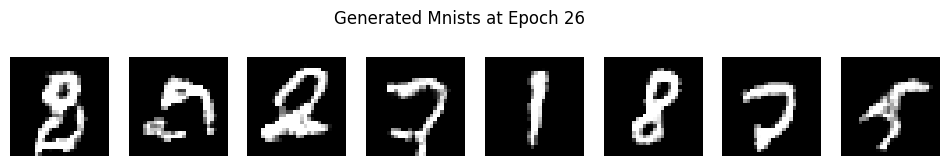

Epoch 27/30: 100%|██████████| 938/938 [01:05<00:00, 14.22it/s]


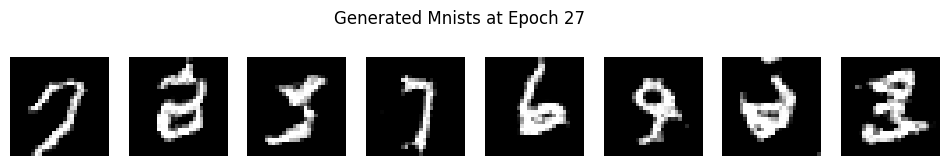

Epoch 28/30: 100%|██████████| 938/938 [01:06<00:00, 14.02it/s]


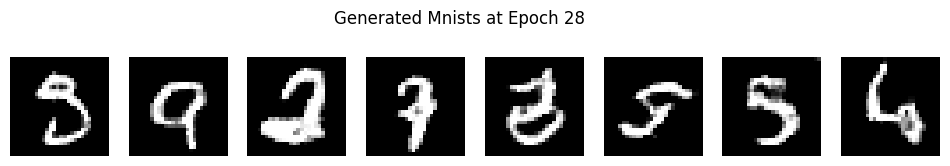

Epoch 29/30: 100%|██████████| 938/938 [01:07<00:00, 13.91it/s]


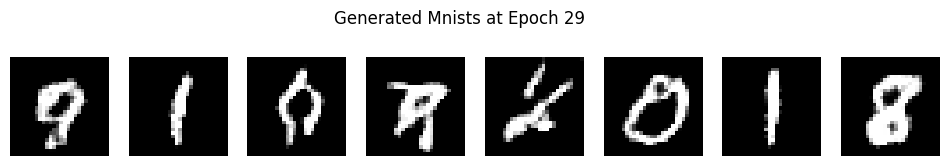

Epoch 30/30: 100%|██████████| 938/938 [01:07<00:00, 13.90it/s]


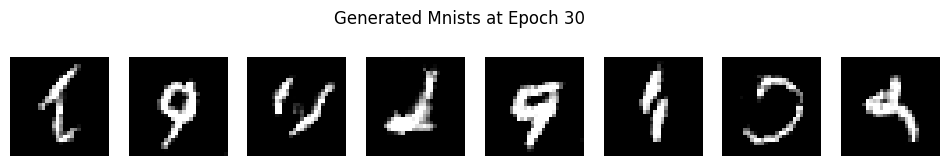

In [29]:
energy_model = DynamicEnergyNet().to(computation_device)
opt = optim.Adam(energy_model.parameters(), lr=0.001)
losses, accuracies = train_model(energy_model,training_loader,testing_loader,opt,epochs=30,langevin_steps=30)

Plot the training curve.

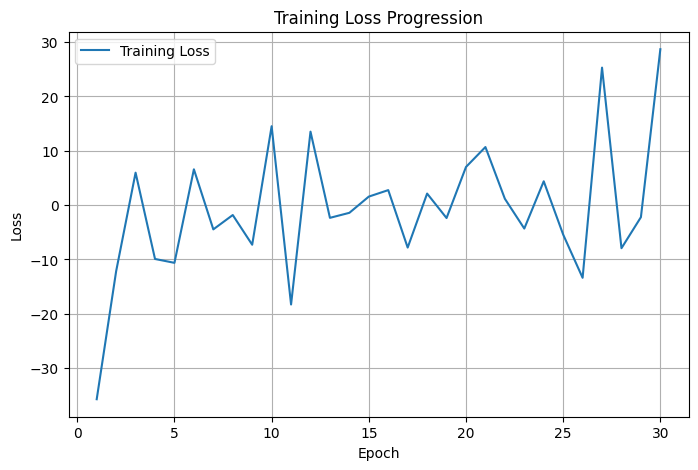

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses) + 1), losses, label='Training Loss')
plt.title('Training Loss Progression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


Now visualize generated samples. (You can visualize images every few epochs to see the evolution of your network)

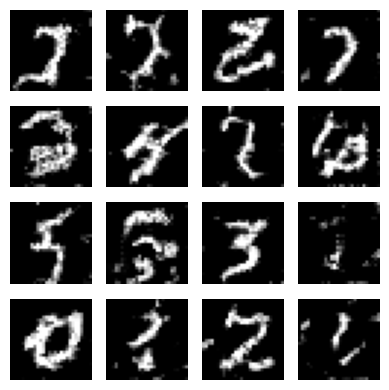

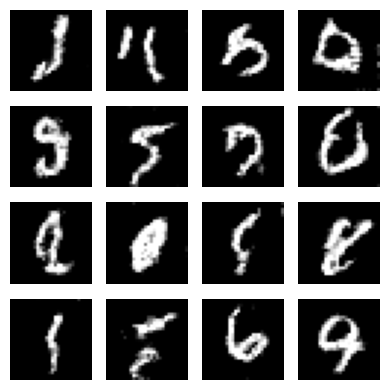

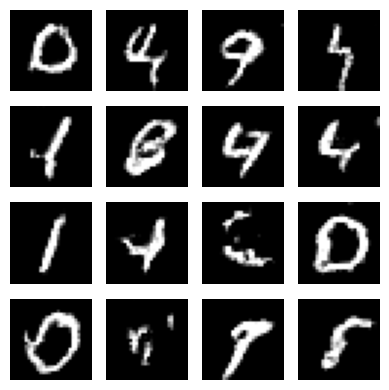

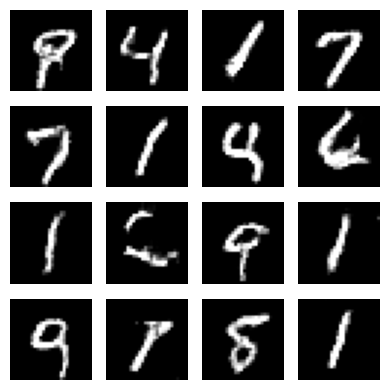

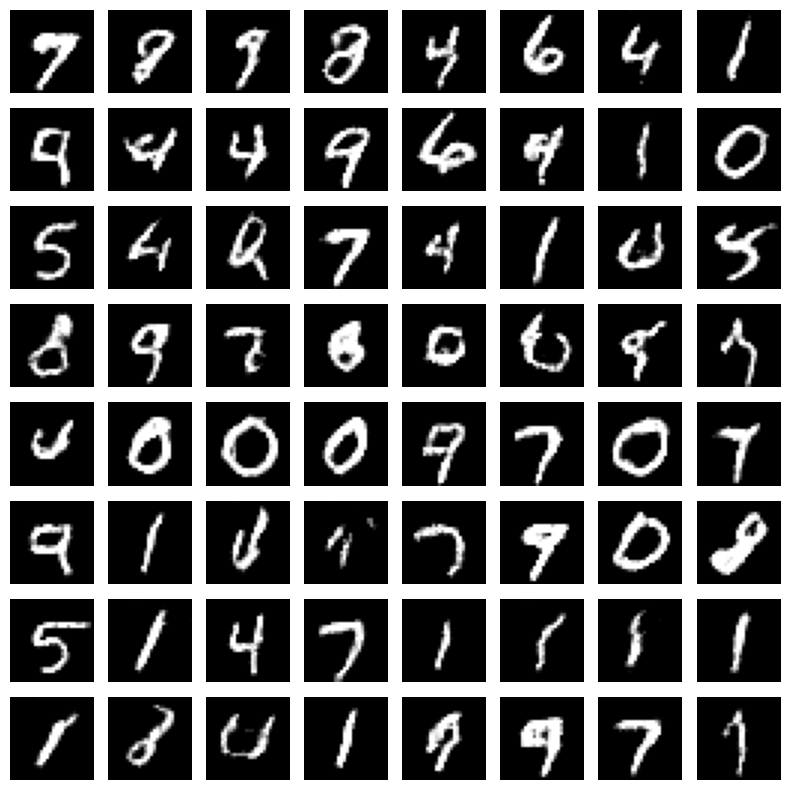

In [37]:
show_generated_samples(energy_model, grid_dim=4, langevin_steps=10)
show_generated_samples(energy_model, grid_dim=4, langevin_steps=20)
show_generated_samples(energy_model, grid_dim=4, langevin_steps=30)
show_generated_samples(energy_model, grid_dim=4, langevin_steps=40)
show_generated_samples(energy_model, grid_dim=8, langevin_steps=50)

If your resutls aren't great you can tune the hyperparameters to get better results or alternatively you can modify the dataset (resize, ...)to make it easier to learn the energy function.